### 6.1 Working with text data

文本是最常见的序列数据之一，一般理解为单词序列。由于深度学习模型并非接收原始文本作为输入，它只能处理数值张量。因此要先将文本向量化vectorize，一般有以下几种实现方法：

- 将文本分割为单词，并将每个单词转换为一个向量
- 将文本分割为字符，并将每个字符转换为一个向量
- 提取单词或字符的n-gram，并将每个n-gram转换为一个向量。n-gram是多个相邻单词或字符的集合，n-gram之间可以重叠。

将文本分解而成的单元(单词、字符或n-gram)叫作token，将文本分解为标记的过程叫作分词(tokenization)。所有文本向量化过程都是**应用某种分词方案，然后将数值向量与生成的标记相关联。**本接介绍两种方法，one-hot encoding与token embedding。

n-gram的词袋模型是一种特征工程工具，不适用于深度学习模型，但对于轻量级的浅层文本处理模型(如logistic回归和random forest)是重要且不可或缺的。

#### 6.1.1 One-hot encoding of words and characters

one-hot编码是将token转换为向量最基本的方法。它将每个单词和一个唯一的整数index相关联，并将这个整数index转换为长度为N的二进制向量(N是词表大小)。

下面是单词级的one-hot编码和字符级的one-hot编码的简单示例：

In [1]:
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1

max_length = 10

results = np.zeros(shape=(len(samples),
                          max_length,
                          max(token_index.values())+ 1))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1

Keras中提供了内置函数，其可以对原始文本数据进行单词级或字符级的one-hot编码。这些函数一般实现了许多重要特性，应该使用它们对文本数据进行编码处理。

In [3]:
# 6-3 Using Keras for word-level one-hot encoding
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)

# to list
sequences = tokenizer.texts_to_sequences(samples)

# to one-hot tensor
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


one-hot encoding的一种变体是one-hot hashing trick，适用于词表中token数目太大而无法直接处理的情况。这种方法没有为每个单词显示分配一个index，而是将单词hash encode为固定长度的向量，这一步通常用一个简单的hash function实现。优点在于避免维护一个显式的单词索引，从而能够节省内存并允许数据的online encoding(在读取完所有数据前即可生成encoding)；缺点在于可能出现hash collision。

#### 6.1.2 Using word embeddings

word embedding相比于one-hot编码的词向量，具有以下特征：
- one-hot词向量稀疏、高维、hard-code
- word embedding密集、低维且从数据中学习得到

word embedding的获取有两种方法：
- 在完成主任务的同时学习该任务上的embedding。
- 在不同于待解决问题的机器学习任务上预先计算好word embedding，然后将其加载到模型中，这种word embedding叫作pretrained word embedding。

##### Learning word embedding with Embedding layer

词向量之间的几何关系应该表示这些词之间的语义关系。也即word embedding的作用应该是将人类的语言映射到几何空间中。词与词之间的distance和direction应该都是meaningful的。

对于一特定任务如需学习一个其word embeddings对应的嵌入空间，意味着要学习一个层的weights，这个层也即是Embedding层。

In [8]:
from keras.layers import Embedding

embedding_layer = Embedding(1000, 64)

Embedding层至少需要两个参数，input_dim可理解为token个数，output_dim可理解为embedding的维度。这样一来，Embedding层就可以被视为一个字典，它将单词的整数索引映射为密集向量，实际上就是一种字典查找。

这个Embedding层的input应该是一个shape为(samples, sequence_length)的张量，其中sequence_length用zero padding等方法做到长度一致。而output的shape应该是(samples, sequence_length, embedding_dimensionality)，之后可以用RNN层或者1D conv层来处理这个三维张量。

下面在IMDB的电影评论数据集上训练一个word embedding，将评论长度限制为只有20个单词，词表选择前10000个单词。

In [11]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=
                                                     max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [12]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10, batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 36s 2ms/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/10
20000/20000 [==============================] - 8s 415us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 9s 432us/step - loss

可以看到最后训练出的Embedding层的表示用于二分类任务的分类精度约为75%。但是用Dense层而非序列模型的RNN unit作分类会导致模型对输入序列中的每个单词单独处理，而并没有考虑单词之间的关系和句子结构。

##### Using pretrained word embedding

当手头可用的训练数据很少时，可从pretrained的embedding空间加载word embedding。通常这个pretrained embedding space是高度结构化的，且抓住了语言结构的一般特点。这样可以不必在解决问题的同时学习word embedding。

有许多pretrained的word embedding，都可以下载并在Keras的Embedding层中使用，如word2vec和GloVe。

#### 6.1.3 Putting it all together: from raw text to word embeddings

本节中将使用GloVe作为embedding实现IMDB数据集上的情感分类，其中IMDB的数据将使用IMDB的原始文本数据，而不是Keras内置的已经预先分词的IMDB数据。

In [3]:
import os

imdb_dir = r'C:\Users\10750\Desktop\notebook\datasets\aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),'r',encoding='UTF-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # maximum 100 words per comment in IMDB
# validation of GloVe, so only train on 200 samples
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s unique tokens in full set.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# shuffle process
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

88582 unique tokens in full set.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [5]:
glove_dir = r'C:\Users\10750\Desktop\notebook\datasets\glove.6B'

embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), 'r', encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embedding_index))

Found 400000 word vectors.


In [6]:
# prepare the embedding matrix to load into Embedding Layer
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [7]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
# ? why Embedding out_dim shape=(None, 100, 100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [9]:
# load GloVe Embedding
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False # freeze the pretrained layer

In [11]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 4s 20ms/step - loss: 1.4617 - acc: 0.4600 - val_loss: 0.6944 - val_acc: 0.5282
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6007 - acc: 0.6400 - val_loss: 0.9004 - val_acc: 0.4956
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4924 - acc: 0.7650 - val_loss: 0.6964 - val_acc: 0.5448
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4251 - acc: 0.8650 - val_loss: 0.7815 - val_acc: 0.5181
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3012 - acc: 0.8900 - val_loss: 0.7326 - val_acc: 0.5333
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3427 - acc: 0.8600 - val_loss: 1.0132 - val_acc: 0.4960
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1702 - acc: 0.9600 - val_loss: 0.8879 - val_acc: 0.5260
Epoch 8/10
200/200 [=======

### 6.2 Understanding recurrent neural networks

在此之前，我们见到的所有neural networks都有一个共同特点：它们没有记忆。对于一段文本这样的序列化输入，network将整个序列转换为单个输入张量并feed到feedforward network中，但这显然和人类理解text的方法是不同的。

人阅读一个句子的时候，一般是一个单词一个单词阅读，在一次阅读中会同时记住之前的内容，从而动态理解这个句子的含义。

RNN，即循环神经网络采用相同的原理，在model内保存一个state，包含与已知内容相关的信息，并在单个的序列上遍历输入。下面用Numpy来实现一个简单RNN的forward：RNN的输入是一个shape为(timesteps, input_features)的2D tensor，在每个timestep，model考虑t时刻的当前状态和t时刻的当前输入，对二者进行计算得到t时刻的输出，然后将下一个timestep的状态设置为上一个timestep的输出。用伪代码表示如下:

state_t = 0 # initial state
for input_t in input_sequence:
    # output_t = f(input_t, state_t)
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

In [12]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random(size=(timesteps, input_features))

# initial state: zero initialization
state_t = np.zeros((output_features, ))

# random weights matrix
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = [] # sequential output
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    
    successive_outputs.append(output_t)
    
    state_t = output_t
    
final_output_sequence = np.stack(successive_outputs, axis=0)

以上cell中的代码是Numpy中RNN的简单实现，其使用一个for循环，重复使用循环中前一次迭代的计算结果。RNN的特征在于其timestep函数。

many-to-one的task下，通常只需要最后一个timestep的输出，因为其已经包含了整个序列的信息。

#### 6.2.1 A recurrent layer in Keras

上面Numpy的简单实现，对应了Keras层中的SimpleRNN层：
from keras.layers import SimpleRNN
尽管两者有一些区别：SimpleRNN可以处理批量数据，即(batch_size, timesteps, input_features)shape的输入。

同样的，考虑到RNN可能对应many-to-many或many-to-one的任务，SimpleRNN也可以在两种模式下运行:返回(batch_size, timesteps, input_features)的完整输出序列或只返回(batch_size, input_features)的最终输出，由return_sequences参数控制。

In [14]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


有时候为了提高网络的表示能力，将多个RNN层逐个堆叠起来也是很有用的。在这种情况下中间层必须返回完整的输出序列：

In [15]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


下面，我们将RNN model应用于IMDB情感分类问题：

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

input_train = sequence.pad_sequences(input_train,maxlen=maxlen)
input_test = sequence.pad_sequences(input_test,maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [18]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10, batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 55s 3ms/step - loss: 0.6428 - acc: 0.6140 - val_loss: 0.5919 - val_acc: 0.6680
Epoch 2/10
20000/20000 [==============================] - 55s 3ms/step - loss: 0.4190 - acc: 0.8197 - val_loss: 0.4217 - val_acc: 0.8208
Epoch 3/10
20000/20000 [==============================] - 48s 2ms/step - loss: 0.2999 - acc: 0.8804 - val_loss: 0.3777 - val_acc: 0.8306
Epoch 4/10
20000/20000 [==============================] - 51s 3ms/step - loss: 0.2484 - acc: 0.9024 - val_loss: 0.3601 - val_acc: 0.8530
Epoch 5/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.2203 - acc: 0.9127 - val_loss: 0.3728 - val_acc: 0.8730
Epoch 6/10
20000/20000 [==============================] - 47s 2ms/step - loss: 0.1512 - acc: 0.9455 - val_loss: 0.3916 - val_acc: 0.8708
Epoch 7/10
20000/20000 [==============================] - 49s 2ms/step - loss: 0.1037 - acc: 0.9633 - val_loss: 0.5807 - val_acc:

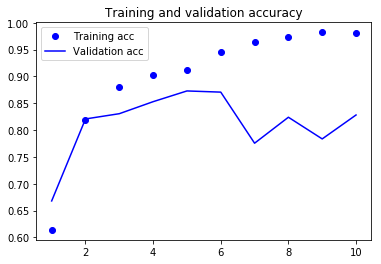

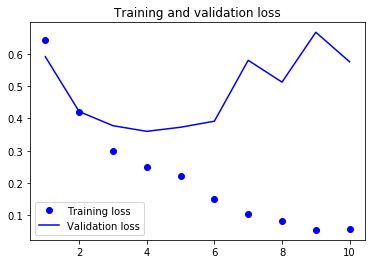

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

从上面的acc图可以看出，这个RNN的表现甚至不如第一个simple method的baseline。原因包括了：输入只考虑了前500个单词而非整个序列；SimpleRNN并不擅长处理长序列，比如文本。

#### 6.2.2 Understanding LSTM and GRU layers


在实际的应用中，我们一般是不可能使用到SimpleRNN的，而是使用更高级的循环层:LSTM和GRU。SimpleRNN的最大问题是：在时刻t，理论上来说它应该能，记住很多timestep之前见到的信息，但实际上它**无法学习到这种长期依赖**，这是由于梯度消失问题vanishing gradient problem。

梯度消失问题在层数较多的feedforward network中同样存在：随着层数的增加，网络最终变得无法训练。

LSTM层背后的LSTM long short-term memory算法是Hochreiter和Schmidhuber于1997年发表，是二人研究梯度消失问题的重要成果。

LSTM层是SimpleRNN层的一种变体，它增加了**一种携带信息跨越多个timestep的方法**，它保存信息以便以后使用，从而防止较早期的信号在处理过程中逐渐消失。

在SimpleRNN的基础之上，LSTM加入了额外的数据流，其中的信息是跨timestep的：在t时刻，ct表示t时刻carry的信息，用伪代码表示如下：
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t, Vo) + bo)

i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)

f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)

k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

c_t+1 = i_t * k_t + c_t * f_t

p.s. 这本书对于LSTM原理阐述的还是太浅了，需要读LSTM的原论文或是cs224n的课程内容再深入理解其原理，毕竟在序列模型里太重要了。

#### 6.2.3 A concrete LSTM example in Keras

In [5]:
from keras.layers import LSTM, Embedding, Dense
from keras import models

model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 204s 10ms/step - loss: 0.5007 - acc: 0.7659 - val_loss: 0.3356 - val_acc: 0.8704
Epoch 2/10
20000/20000 [==============================] - 199s 10ms/step - loss: 0.2900 - acc: 0.8859 - val_loss: 0.3034 - val_acc: 0.8698
Epoch 3/10
20000/20000 [==============================] - 209s 10ms/step - loss: 0.2336 - acc: 0.9110 - val_loss: 0.3445 - val_acc: 0.8822
Epoch 4/10
20000/20000 [==============================] - 222s 11ms/step - loss: 0.1999 - acc: 0.9254 - val_loss: 0.2968 - val_acc: 0.8738
Epoch 5/10
20000/20000 [==============================] - 250s 12ms/step - loss: 0.1742 - acc: 0.9348 - val_loss: 0.3045 - val_acc: 0.8822
Epoch 6/10
20000/20000 [==============================] - 224s 11ms/step - loss: 0.1608 - acc: 0.9426 - val_loss: 0.3230 - val_acc: 0.8712
Epoch 7/10
20000/20000 [==============================] - 234s 12ms/step - loss: 0.1435 - acc: 0.9497 - val_loss: 0.4

从训练10个epoch的结果来看，LSTM的结果要比SimpleRNN好很多，但相较Dense的简单模型的提升有限。主要的原因在于：适用于评论分析全局的长期性结构(这正是LSTM所擅长的)，对情感分析问题帮助不大。对于这样的基本问题，观察每条评论里出现的单词和词频往往就可以很好解决，这也是第一个全连接方法的做法。而一些更加困难的NLP问题，特别是问答和机器翻译上，LSTM的优势就明显了。

### 6.3 Advanced use of recurrent neural networks

本节将介绍提高循环神经网络性能和泛化能力的三种高级技巧，并在温度预测问题中引入这三个概念。这一问题中，数据点的时间序列来自于建筑物屋顶安装的传感器，包括温度、气压、湿度等features，需要利用这些数据来预测最后一个数据点24小时后的温度。

本节将介绍以下三种技巧：
- 循环dropout(recurrent dropout)，这种内置方法在循环层中使用dropout降低overfitting
- 堆叠循环层(stacking recurrent layers)，这样可以提高网络的表示能力，尽管是以更高的computation cost为代价
- 双向循环层(bidirectional recurrent layer)，将相同的信息以不同方式呈现给循环神经网络，可以提高精度并缓解遗忘问题。

#### 6.3.1 A temperature-forecasting problem

并不只是文本数据才叫序列数据，序列数据的涵盖面很宽泛，只要数据之间有着按照上下文、时间等逻辑关系的排列即可算作sequence data。下面我们将要使用一个天气时间序列数据集，它由德国的马克思-普朗克生物地球化学研究所的气象站记录。

In [7]:
import os

data_dir = r'C:\Users\10750\Desktop\notebook\datasets\jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


这个数据站每10分钟记录一个数据点，共有420551行数据，每行即一个timestep，记录了一个日期和14个和天气有关的值。

下面，将这些数据解析为一个Numpy数组：

In [8]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

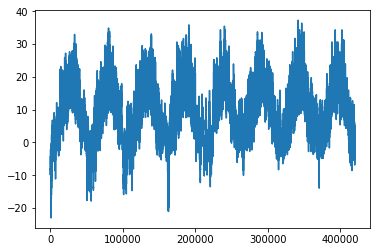

In [12]:
import matplotlib.pyplot as plt

temp = float_data[:, 1] # temperature
plt.plot(range(len(temp)), temp)

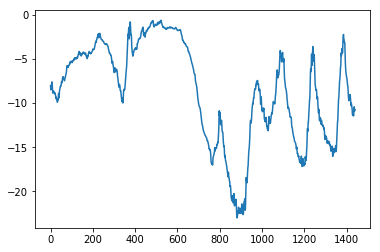

In [13]:
# the beginning 10 days' temperature
plt.plot(range(1440), temp[:1440])

#### 6.3.2 Preparing the data

这个问题确切的表述如下：一个timestep是10分钟，每steps个timesteps采样一次数据，如果给定过去lookback个timesteps之内的数据，能否预测delay个timesteps后的温度？所用参数值如下：
- lookback=720，即给定的是过去5天内的观测数据
- steps=6，观测数据的采样频率是每小时一个数据点
- delay=144，目标是未来24小时后的数据

preparing the data包括以下两部分：
- normalization，将不同feature的每个时间序列的数据做标准化，让它们在相似的范围内都取较小的值
- 写一个Python generator来即时生成样本。

In [14]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [15]:
# ? not sure about the definition of generator
def generator(data, lookback, delay, min_index, max_index,
               shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [16]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) //batch_size

#### 6.3.3 A common-sense, non-machine-learning baseline

在建立深度学习模型之前，我们可以先尝试一种基于common-sense的简单方法作为baseline。这种常识有多理想化并不重要，只要它能取得一个可作为baseline的结果即可。

在本例中，我们可以假设，温度每天的变化都是周期性的。因此，一种common-sense的方法就是始终预测24小时后的温度等于现在的温度。我们可以采用MAE来评估这种方法。

In [17]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


In [20]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

也就是说，这种假设得到的结果与target的平均绝对误差为2.57℃，这个误差还是相当大的，接下来我们用深度学习的方法改进这个baseline。

#### 6.3.4 A basic machine-learning approach

在尝试机器学习方法前，基于common-sense建立一个baseline是很有用的；同样的，在尝试比较复杂且computation cost比较高的模型(LSTM)之前，尝试使用简单的模型也是很有用的，比如小型的Dense网络。这可以保证进一步增加问题的复杂度是合理的。

In [21]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['acc'])
# 其实不需要metircs，因为与target也没法直接计算acc，只能用mae loss denormal成具体误差
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 17s 33ms/step - loss: 1.1010 - acc: 0.0000e+00 - val_loss: 0.4980 - val_acc: 0.0000e+00
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3844 - acc: 0.0000e+00 - val_loss: 0.4137 - val_acc: 0.0000e+00
Epoch 3/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2871 - acc: 0.0000e+00 - val_loss: 0.3213 - val_acc: 0.0000e+00
Epoch 4/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2611 - acc: 0.0000e+00 - val_loss: 0.3710 - val_acc: 0.0000e+00c: 0.0
Epoch 5/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2527 - acc: 0.0000e+00 - val_loss: 0.3340 - val_acc: 0.0000e+00: 7s - loss: 0.25 - ETA: 5s - loss: 0.2597 - acc: 0.0000e+ - ETA: 5s - lo - ETA: 4s - loss: 0.2557 - acc: - ETA: 3s - loss - ETA: 2s - loss: 0.2543 - acc: 0.0000e+0 - ETA: 2s - loss: 0.2541  - ETA: 1s - loss: 
Epoch 6/20
500/500 [==============================] - 16s 32ms/step - loss:

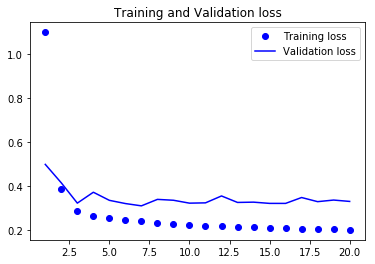

In [22]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

可以看到，两层Dense层的模型表现得甚至并不如我们基于common-sense的简单模型，为什么它在假设空间上甚至没有找到我们最开始假定的简单模型呢？
事实上，这对机器学习是一个非常重要的限制：*如果学习算法没有被硬编码要求去寻找特定类型的简单模型，那么有时候参数学习是无法找到简单问题的简单解决方案的*。

#### 6.3.5 A first recurrent baseline

第一个全连接方法的效果不好并不意味着ML不适用于这个问题。它首先将时间序列Flatten处理，这就从输入数据中删除了时间的概念，而序列化的表示对于这个问题的数据是非常重要的。

我们首先使用GRU层作为一个循环网络的baseline，因为GRU层相当于是LSTM的简化，计算代价要更小。

In [23]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1]))) # None-adaptive shape
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/20
500/500 [==============================] - 283s 566ms/step - loss: 0.2969 - val_loss: 0.2689
Epoch 2/20
500/500 [==============================] - 277s 555ms/step - loss: 0.2850 - val_loss: 0.2698
Epoch 3/20
500/500 [==============================] - 270s 540ms/step - loss: 0.2791 - val_loss: 0.2660
Epoch 4/20
500/500 [==============================] - 262s 524ms/step - loss: 0.2748 - val_loss: 0.2637
Epoch 5/20
500/500 [==============================] - 267s 534ms/step - loss: 0.2714 - val_loss: 0.2625
Epoch 6/20
500/500 [==============================] - 266s 533ms/step - loss: 0.2683 - val_loss: 0.2639
Epoch 7/20
500/500 [==============================] - 268s 535ms/step - loss: 0.2632 - val_loss: 0.2697
Epoch 8/20
500/500 [==============================] - 266s 532ms/step - loss: 0.2581 - val_loss: 0.2673
Epoch 9/20
500/500 [==============================] - 265s 531ms/step - loss: 0.2532 - val_loss: 0.2625
Epoch 10/20
500/500 [==============================] - 840s 2s/s

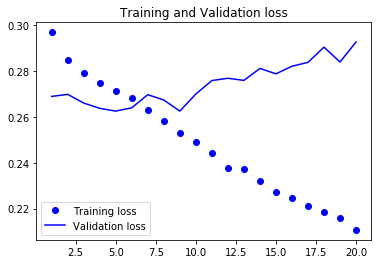

In [24]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

可以看到，单层GRU模型的loss约为0.265，转换为温度的平均绝对误差约为2.35℃，相比于baseline有所提高。

#### 6.3.6 Using recurrent dropout to fight overfitting

从上图的loss结果看，在几轮过后模型开始明显的过拟合，training loss和validation loss开始显著偏离。为解决这一问题，可以在recurrent networks中加入dropout，但这并非一个简单问题。

直到2015年，Yarin Gal的博士论文"Uncertainty in deep learning"才解决了在循环网络中使用dropout这一问题：对于每个timestep使用相同的dropout mask，而不是让mask随着timesteps的增加而随机变化。此外，为了对GRU、LSTM层做regularization，应将不随时间变化的dropout mask应用于inner recurrent activations of the layer(a recurrent dropout mask)。

Keras中的每个循环层有两个与dropout相关的参数，dropout是要给浮点数，指定该层**输入单元的dropout比率**，recurrent_dropout指定**循环单元的dropout比率**。

下面我们向GRU层中添加dropout和recurrent dropout，由于使用dropout做正则化的networks总需要更长时间才能收敛，所以网络训练轮次增加为原有的两倍。

In [43]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 358s 715ms/step - loss: 0.3437 - val_loss: 0.2796
Epoch 2/40
500/500 [==============================] - 374s 748ms/step - loss: 0.3167 - val_loss: 0.2728
Epoch 3/40
500/500 [==============================] - 330s 661ms/step - loss: 0.3097 - val_loss: 0.2718
Epoch 4/40
500/500 [==============================] - 357s 715ms/step - loss: 0.3017 - val_loss: 0.2693
Epoch 5/40
500/500 [==============================] - 319s 639ms/step - loss: 0.2990 - val_loss: 0.2675
Epoch 6/40
500/500 [==============================] - 321s 641ms/step - loss: 0.2963 - val_loss: 0.2696
Epoch 7/40
500/500 [==============================] - 334s 668ms/step - loss: 0.2939 - val_loss: 0.2682
Epoch 8/40
500/500 [==============================] - 332s 665ms/step - loss: 0.2923 - val_loss: 0.2693
Epoch 9/40
500/500 [==============================] - 338s 677ms/step - loss: 0.2915 - val_loss: 0.2655
Epoch 10/40
500/500 [==============================] - 358s 716m

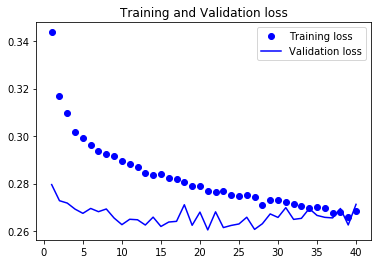

In [44]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

#### 6.3.7 Stacking recurrent layers

在6.3.6中采用了简单的GRU层后，模型不再过拟合，但似乎遇到了performance bottleneck，所以我们应该考虑增加network的capacity。只要overfitting不是太严重，那么performance的不足就很可能出在capacity上。

通常增加network capacity的做法是增加每层的单元数或增加层数。循环层堆叠(recurrent layer stacking)是构建更加强大的循环网络的经典方法。

因此，我们在Keras中逐个堆叠循环层，且所有的中间层应返回完整的输出序列，而不是只返回最后一个timestep的输出，这可以通过指定return_sequences=True来实现。

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64,activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

从结果上可以看出来，虽然stacking在performance上有提高，但这样的提高并不显著。或者说在这种构架下，提高网络能力的回报在逐渐减小。

#### 6.3.8 Using bidirectional RNNs

双向RNN是一种常见的RNN变体，在某些任务上的性能要比普通RNN更好。双向RNN常用于自然语言处理，you could call it the Swiss Army knife of deep learning for natural-language processing.

双向RNN包含了两个普通的RNN，如GRU或LSTM层，每个RNN分别沿着一个方向对输入序列进行处理(时间正序和时间逆序)，然后将它们的表示合并在一起。通过沿着两个方向处理序列，双向RNN能够捕捉到可能被单向RNN忽略的模式。

有时候正序模型未必比逆序模型更好。比如在imdb上用逆序LSTM训练模型的结果几乎和正序的结果一样好。这证实了一个假设：虽然单词顺序对理解语言很重要，但使用哪种顺序建立模型并不重要。

更重要的一点是：如果逆序序列上训练的RNN模型学到的表示不同于在原始序列上学到的表示，那么这种表示是非常有用的，因为它们提供了查看数据的全新角度，抓住了数据中被某一个方法忽略的内容，因此可以提高模型在某个任务上的性能。这也是ensembling方法背后的直觉。

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

我们就不训练这个网络了，事实上，它的结果和普通的GRU层差不多一样好。其原因很容易理解：所有的预测能力肯定都来自于正序的那一半网络，因为我们已经知道，逆序的那一半在这个任务上的表现非常糟糕（本例同样是因为，最近的数据比久远的数据更加重要）。

### 6.4 Sequence processing with convnets

对某些序列处理问题，一维卷积神经网络的效果可以媲美RNN，而且计算代价要小得多。最近，一维卷积神经网络［通常与空洞卷积核（dilated kernel）一起使用］已经在音频生成和机器翻译领域取得了巨大成功。除了这些具体的成就，人们还早已知道，对于文本分类和时间序列预测等简单任务，小型的一维卷积神经网络可以替代RNN，而且速度更快。

#### 6.4.1 Understanding 1D convolution for sequence data

一维卷积层其实就是在一个窗口范围中，用weights与这段序列做点积，得到输出特征。这种1D convolution可以识别序列中的局部模式。因为对每个序列段执行相同的输入变换，所以在句子中某个位置学到的模式稍后可以在其他位置被识别，这使得1D convolution具有平移不变性(对时间平移而言)。举个例子，使用大小为5 的卷积窗口处理字符序列的一维卷积神经网络，应该能够学习长度不大于5 的单词或单词片段，并且应该能够在输入句子中的任何位置识别这些单词或单词段。因此，character-level的1D co能够学会单词构词法。

#### 6.4.3 Implementing a 1D convnet

Keras中的1D convnet是Conv1D层。其接收tensor的shape为(samples, time, features)的三维张量，并返回类似于shape的三维张量。卷积窗口是时间轴上的一维窗口。

In [54]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


Conv1D和二维的卷积神经网络在架构上没什么不同，都是Conv1D层和MaxPooling1D层的堆叠，最后是一个全局池化或者Flatten层，最后用一个Dense层做分类或回归。

不过二者有一点不同，一维的卷积神经网络可以使用**更大的卷积窗口**。对于二维卷积层，3×3 的卷积窗口包含3×3=9 个特征向量；但对于一位卷积层，大小为3 的卷积窗口只包含3个卷积向量。因此，你可以轻松使用大小等于7 或9 的一维卷积窗口。

In [55]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPool1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 11s 565us/step - loss: 0.8337 - acc: 0.5095 - val_loss: 0.6874 - val_acc: 0.5664
Epoch 2/10
20000/20000 [==============================] - 9s 464us/step - loss: 0.6699 - acc: 0.6384 - val_loss: 0.6641 - val_acc: 0.6576
Epoch 3/10
20000/20000 [==============================] - 9s 471us/step - loss: 0.6235 - acc: 0.7530 - val_loss: 0.6079 - val_acc: 0.7424
Epoch 4/10
20000/20000 [==============================] - 10s 509us/step - loss: 0.5256 - acc: 0.8075 - val_loss: 0.4842 - val_acc: 0.8054
Epoch 5/10
20000/20000 [==============================] - 10s 486us/step - loss: 0.4113 - acc: 0.8489 - val_loss: 0.4290 - val_acc: 0.8294
Epoch 6/10
20000/20000 [==============================] - 10s 517us/step - loss: 0.3510 - acc: 0.8690 - val_loss: 0.4132 - val_acc: 0.83708 - acc - ETA: 5s - loss: 0.3498 - acc: - ETA: 5s - - ETA: 1s - loss
Epoch 7/10
20000/20000 [===========================

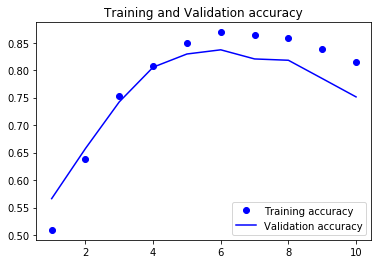

In [57]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.show()

#### 6.4.4 Combining CNNs and RNNs to process long sequences

一维卷积神经网络分别处理每个输入序列段，所以它对时间步的顺序不敏感（这里所说顺序的范围要大于局部尺度，即大于卷积窗口的大小），这一点与RNN 不同。当然，为了识别更长期的模式，你可以将许多卷积层和池化层堆叠在一起，这样上面的层能够观察到原始输入中更长的序列段，但这仍然不是一种引入顺序敏感性的好方法。想要证明这种方法的不足，一种方法是在温度预测问题上使用一维卷积神经网络，在这个问题中顺序敏感性对良好的预测结果非常关键。以下示例复用了前面定义的这些变量：float_data、train_gen、val_gen 和val_steps。

In [58]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 23s 45ms/step - loss: 0.4194 - val_loss: 0.4358
Epoch 2/20
500/500 [==============================] - 20s 40ms/step - loss: 0.3640 - val_loss: 0.4471
Epoch 3/20
500/500 [==============================] - 23s 46ms/step - loss: 0.3402 - val_loss: 0.4510
Epoch 4/20
500/500 [==============================] - 23s 45ms/step - loss: 0.3232 - val_loss: 0.45501s - - ETA: 0s - loss: 
Epoch 5/20
500/500 [==============================] - 24s 48ms/step - loss: 0.3103 - val_loss: 0.4465
Epoch 6/20
500/500 [==============================] - 27s 54ms/step - loss: 0.3018 - val_loss: 0.4594
Epoch 7/20
500/500 [==============================] - 23s 47ms/step - loss: 0.2935 - val_loss: 0.4826
Epoch 8/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2882 - val_loss: 0.5061
Epoch 9/20
500/500 [==============================] - 22s 43ms/step - loss: 0.2791 - val_loss: 0.4840
Epoch 10/20
500/500 [==============================] - 20s 

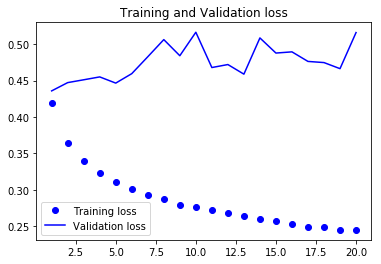

In [59]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

可以看到，验证的loss仍在0.4-0.5之间，这甚至不如我们基于common-sense的baseline方法。同样，这是因为卷积神经网络在输入时间序列的所有位置寻找模式，它并不知道所看到某个模式的时间位置（距开始多长时间，距结束多长时间等）。对于这个具体的预测问题，对最新数据点的解
释与对较早数据点的解释应该并不相同，所以卷积神经网络无法得到有意义的结果。卷积神经网络的这种限制对于IMDB 数据来说并不是问题，因为对于与正面情绪或负面情绪相关联的关键词模式，无论出现在输入句子中的什么位置，它所包含的信息量是一样的。

因此，如果我们想要结合1D convnet的速度、轻量和RNN的顺序敏感性，一种方法是通过在RNN之前运用1D convnet作为预处理步骤，提取出序列的特征表示再feed到RNN里训练。对于那些非常长，以至于RNN无法处理的序列(比如包含上千个timesteps的序列)，这种方法尤其有用。

In [60]:
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)

val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [61]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_8 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 119s 239ms/step - loss: 0.3436 - val_loss: 0.2882
Epoch 2/20
500/500 [==============================] - 113s 227ms/step - loss: 0.3053 - val_loss: 0.2787
Epoch 3/20
500/500 [==============================] - 123s 246ms/step - loss: 0.2942 - val_loss: 0.2758
Epoch 4/20
500/500 [==============================] - 131s 261ms/step - loss: 0.2841 - val_loss: 0.2737: 0s - loss: 0
Epoch 5/20
500/500 [==============================] - 126s 253ms/step - loss: 0.2769 - val_loss: 0.2952
Epoch 6/20
500/500 [==============================] - 126s 253ms/step - loss: 0.2709 - val_loss: 0.2855
Epoch 7/20
500/500 [==============================] - 119s 239ms/step - loss: 0.2658 - val_loss: 0.2884
Epoch 8/20
500/500 [==============================] - 119s 237ms/step - loss: 0.2595 - val_loss: 0.2967
Epoch 9/20
500/500 [==============================] - 112s 223ms/step - loss: 0.2556 - val_loss: 0.2791
Epoch 10/20
500/500 [=============================

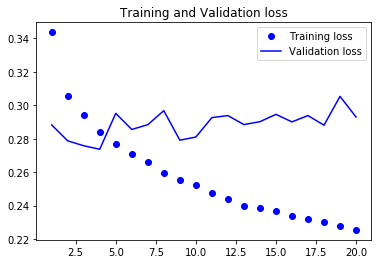

In [63]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

结果还算不错，略逊于单独的GRU(毕竟在GRU之前的降维还是有信息损失)，但速度要快很多。

Here's what you should take away from this section:
- 和二维convnets类似，1D convnets适于处理时间模式。对于某些问题，特别是NLP任务，它可以替代RNN且速度更快。
- 通常情况下，1D convnet的架构和视觉上的2D convnets非常相似，它将Conv1D层和MaxPooling1D层堆叠在一起，最后是一个global pooling或flatten操作。
- 因为RNN在处理非常长的序列时计算代价很大，但1D convnet的computational cost很小，所以在RNN之前使用1D convnet作为preprocessing是一个好主意，这样可以使序列变短，并提取有用的representation给RNN处理。